In [1]:
import torch
import torchvision

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.model_selection import train_test_split


# Classification of M, P & I

base model: AlexNet

In [2]:
# experiment hyperparameters
image_path = '/home/riikoro/fossil_data/tooth_samples'
versions = [3,4,5]
batch_size = 8 # random

## Prepare labels

In [3]:
def id_to_tooth(id):
    if id == 0:
        return 'M'
    elif id == 1:
        return 'P'
    elif id == 2:
        return 'I'

def label_to_tooth(label):
    return id_to_tooth(np.argmax(label))

In [4]:
def clean_azure_labels(data_version, label_filename='azure_labels.txt',names=['tooth']):
    tooth_labels = pd.read_csv(f'{image_path}/v{data_version}/{label_filename}', header=None, names=names)
    tooth_labels['tooth_type'] = tooth_labels['tooth'].str[0] # extract first character
    del tooth_labels['tooth']
    # set labels where tooth type is unexpected to nont
    tooth_labels.loc[~tooth_labels['tooth_type'].isin(['m', 'p', 'i', 'M', 'P', 'I']), 'tooth_type'] = None
    # uppercase all tooth type letters
    tooth_labels['tooth_type'] = tooth_labels['tooth_type'].str.upper()
    tooth_labels.dropna(inplace=True)
    # add column for image index & data version to allow combining datasets
    tooth_labels['image_i'] = tooth_labels.index
    tooth_labels['data_v'] = data_version
    return tooth_labels

labels_v3 = clean_azure_labels(3)
labels_v4 = clean_azure_labels(4)
labels_v5 = clean_azure_labels(5, 'labels.txt', ['u', 'tooth'])
tooth_labels = pd.concat([labels_v3, labels_v4, labels_v5], axis=0)
del tooth_labels['u']
tooth_labels

,tooth_type,image_i,data_v
0,M,0,3
3,M,3,3
4,P,4,3
5,M,5,3
7,M,7,3
...,...,...,...
44,I,44,5
45,I,45,5
46,I,46,5
47,I,47,5


In [5]:
def translation_augment(tooth_type, tx, ty):
    translated_images = []
    translation_matrix = np.array([[1.,0.,tx],[0.,1.,ty]])
    for i, p_row in tooth_labels[tooth_labels['tooth_type'] == tooth_type].iterrows():
        image = cv2.imread(f'{image_path}/v{p_row["data_v"]}/{p_row["image_i"]}.png', cv2.IMREAD_GRAYSCALE)
        height, width = image.shape[:2]
        translated_image = cv2.warpAffine(src=image, M=translation_matrix, dsize=(width, height), borderMode=cv2.BORDER_CONSTANT,borderValue=255)
        translated_images.append(translated_image)
    return translated_images

new_Ps = translation_augment('P', -2., 1.)
new_Is = []
translations = [(-7,1), (-4,1), (1, -4), (1, 4)]
for i in range(4): # translate each image 5 times to obtain enough incisors
    new = translation_augment('I', translations[i][0], translations[i][1])
    new_Is.extend(new)

[ WARN:0@2.197] global loadsave.cpp:241 findDecoder imread_('/home/riikoro/fossil_data/tooth_samples/v5/48.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

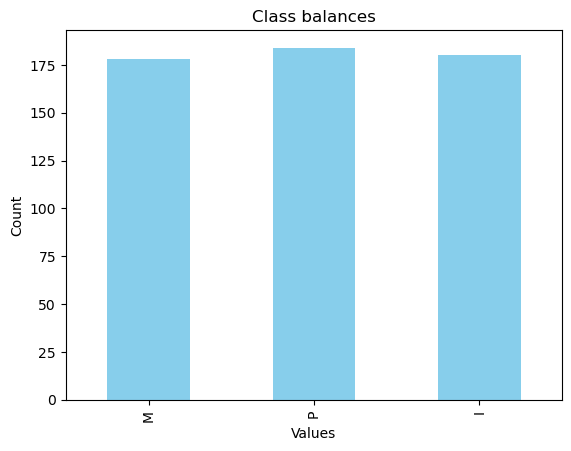

0.33948339483394835

In [6]:
value_counts = tooth_labels['tooth_type'].value_counts()
value_counts['P'] += len(new_Ps)
value_counts['I'] += len(new_Is)

# Plot a bar chart
value_counts.plot(kind='bar', color='skyblue')

# Add title and labels
plt.title('Class balances')
plt.xlabel('Values')
plt.ylabel('Count')

# Display the plot
plt.show()

fraction = value_counts.max() / value_counts.sum()
fraction

## Load images

In [7]:
def transform(sample):
    sample = 255-sample
    sample = cv2.GaussianBlur(sample, (5, 5), 0)
    _, sample = cv2.threshold(sample, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return sample

In [8]:
tooth_images = []
for i, label in tooth_labels.iterrows():
    filename = f'{image_path}/v{label["data_v"]}/{label["image_i"]}.png'
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    tooth_images.append(image)

# add augmented images
tooth_images.extend(new_Ps)
tooth_images.extend(new_Is)

resize = lambda image: cv2.resize(image,(256,256), interpolation = cv2.INTER_AREA)
resized_images = list(map(resize, tooth_images))
teeth = np.array(resized_images)
teeth.shape

(542, 256, 256)

## Define pyTorch dataset & dataloader

In [9]:
# convert labels dataframe to have m p i vector instead of letter
labels = pd.DataFrame()
labels['m'] = (tooth_labels['tooth_type'] == 'M').astype('int')
labels['p'] = (tooth_labels['tooth_type'] == 'P').astype('int')
labels['i'] = (tooth_labels['tooth_type'] == 'I').astype('int')
labels_no_aug = labels.reset_index(drop=True)

# append labels for images obtained with data augmentation
p = pd.DataFrame([[0,1,0]], columns=['m', 'p', 'i'])
new_ps = p.loc[p.index.repeat(len(new_Ps))]

i = pd.DataFrame([[0,0,1]], columns=['m', 'p', 'i'])
new_is = i.loc[i.index.repeat(len(new_Is))]

labels = pd.concat((labels,new_ps,new_is), axis=0).reset_index(drop=True)
labels

,m,p,i
0,1,0,0
1,1,0,0
2,0,1,0
3,1,0,0
4,1,0,0
...,...,...,...
537,0,0,1
538,0,0,1
539,0,0,1
540,0,0,1


m    0
p    0
i    1
Name: 500, dtype: int64


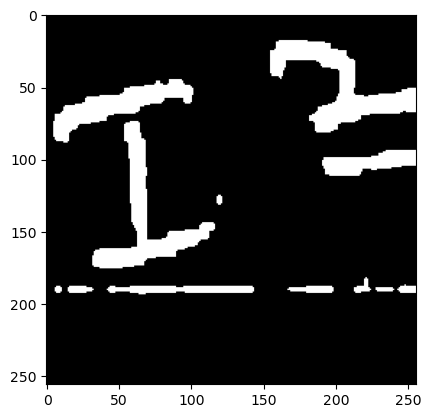

In [10]:
len(labels)
plt.imshow(transform(teeth[500]), cmap='gray')
print(labels.iloc[500])

In [11]:
class MPIDataset(Dataset):
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        preprocessed = self.transform(self.images[idx])
        label = np.array(self.labels.iloc[idx])
        return preprocessed, label

X_train, X_val, Y_train, Y_val = train_test_split(teeth, labels, test_size = 0.1, random_state=1)
train_dataset = MPIDataset(X_train, Y_train, transform)
test_dataset = MPIDataset(X_val, Y_val, transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
tooth_labels

,tooth_type,image_i,data_v
0,M,0,3
3,M,3,3
4,P,4,3
5,M,5,3
7,M,7,3
...,...,...,...
43,I,43,5
44,I,44,5
45,I,45,5
46,I,46,5


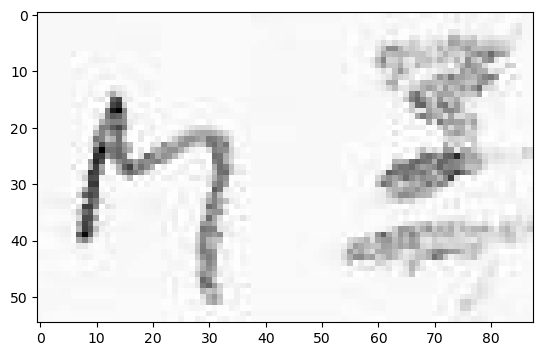

In [13]:
plt.imshow(tooth_images[0], cmap='gray')

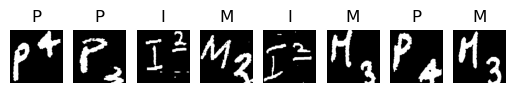

In [14]:
# sanity check
batch = next(iter(train_dataloader))

fig, ax = plt.subplots(1,8)
for i in range(batch_size):
    ax[i].imshow(batch[0][i], cmap='gray')
    ax[i].set_title(label_to_tooth(batch[1][i]))
    ax[i].axis('off')

## Load AlexNet

In [15]:
model = torchvision.models.alexnet()
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

## Freeze & fine-tune

In [179]:
# replace last layer
model.classifier[-1] = nn.Linear(4096, 3)

In [180]:
# freeze layers
for layer in list(model.parameters())[:-1]:
    layer.requires_grad = False

for layer in model.parameters():
    print(layer.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True


In [166]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [143]:
num_epochs = 10